# 07__cis_effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_ctrl(row):
    if "CONTROL" in row["index"]:
        return "control"
    else:
        return "TSS"

In [5]:
def cis_status(row):
    if row.fdr < 0.05:
        return "significant cis effect"
    else:
        return "no cis effect"

In [6]:
def cis_status_detail(row):
    if row.fdr < 0.05:
        if row.logFC < 0:
            return "cis effect\n(higher in human)"
        else:
            return "cis effect\n(higher in mouse)"
    else:
        return "no cis effect"

In [7]:
def cis_status_one(row):
    if row.fdr_cis_HUES64 < 0.05 or row.fdr_cis_mESC < 0.05:
        return "significant cis effect"
    else:
        return "no cis effect"

In [8]:
def cis_status_detail_one(row):
    if row.fdr_cis_HUES64 < 0.05:
        if row.fdr_cis_mESC < 0.05:
            # 2 sig trans effects: check both
            if row.logFC_cis_HUES64 < 0 and row.logFC_cis_mESC < 0:
                return "cis effect\n(higher in human)"
            elif row.logFC_cis_HUES64 > 0 and row.logFC_cis_mESC > 0:
                return "cis effect\n(higher in mouse)"
            else:
                return "cis effect\n(direction interaction)"
        else:
            # only sig in human, only check human
            if row.logFC_cis_HUES64 < 0:
                return "cis effect\n(higher in human)"
            else:
                return "cis effect\n(higher in mouse)"
    else:
        if row.fdr_cis_mESC < 0.05:
            # only sig in mouse, only check mouse
            if row.logFC_cis_mESC < 0:
                return "cis effect\n(higher in human)"
            else:
                return "cis effect\n(higher in mouse)"
        else:
            # no sig effects
            return "no cis effect"

In [9]:
def cis_logFC_one(row):
    if row.fdr_cis_HUES64 < 0.05:
        if row.fdr_cis_mESC < 0.05:
            # 2 sig trans effects: take max of both
            l2fcs = list(row[["logFC_cis_HUES64", "logFC_cis_mESC"]])
            return signed_max(l2fcs)
        else:
            # only sig in human, return human val
            return row.logFC_cis_HUES64
    else:
        if row.fdr_cis_mESC < 0.05:
            # only sig in mouse, return mouse val
            return row.logFC_cis_mESC
        else:
            # no sig effects: take max of both
            l2fcs = list(row[["logFC_cis_HUES64", "logFC_cis_mESC"]])
            return signed_max(l2fcs)

In [10]:
def signed_max(nums):
    abs_nums = np.abs(nums)
    max_idx = np.argmax(abs_nums)
    return nums[max_idx]

## variables

In [11]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_effects_data.txt" % results_dir

In [12]:
data_dir = "../../../data/02__mpra/02__activs"
HUES64_cis_f = "%s/HUES64_cis_results.txt" % data_dir
mESC_cis_f = "%s/mESC_cis_results.txt" % data_dir

In [13]:
tss_map_f = "../../../data/01__design/00__mpra_list/mpra_tss.with_ids.UPDATED.txt"

In [14]:
align_f = "../../../misc/00__tss_metadata/tss_map.seq_alignment.txt"

## 1. import data

In [15]:
results = pd.read_table(results_f)
results.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,HUES64_pval_mm9,mESC_pval_mm9,HUES64_padj_mm9,mESC_padj_mm9,fdr_native,logFC_native,abs_logFC_native,native_status,native_status_detail,native_status_complete
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,3.058408e-03,3.781242e-01,1.073808e-02,6.859042e-01,0.590123,-0.276289,0.276289,no native effect,no native effect,no native effect
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,1.443810e-01,3.737500e-02,3.336436e-01,1.482540e-01,0.000267,2.195646,2.195646,significant native effect,native effect\n(higher in mouse),native effect\n(partial gain in mouse)
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,9.744637e-02,2.678257e-01,2.443024e-01,6.075836e-01,0.171542,-0.494120,0.494120,no native effect,no native effect,no native effect
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,1.537924e-08,8.035852e-10,8.363970e-08,7.340188e-09,0.057673,0.593878,0.593878,no native effect,no native effect,no native effect
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,1.537924e-08,8.035852e-10,8.363970e-08,7.340188e-09,0.068713,-0.563779,0.563779,no native effect,no native effect,no native effect


In [16]:
HUES64_cis = pd.read_table(HUES64_cis_f).reset_index()
mESC_cis = pd.read_table(mESC_cis_f).reset_index()
mESC_cis.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,h.2__div_lnc__m.1__div_lnc,0.214029,0.643628,0.777127,1,14,5,4,-0.200274
1,h.3__div_lnc__m.2__antisense,0.886815,0.346342,0.515658,1,13,5,4,0.725192
2,h.4__antisense_upep__m.3__protein_coding,5.341382,0.020825,0.072360,1,14,5,4,-0.843083
3,h.5__intergenic__m.4__intergenic_upep,0.754080,0.385188,0.557577,1,14,5,4,0.261450
4,h.6__intergenic__m.4__intergenic_upep,4.678432,0.030544,0.094907,1,14,5,4,-0.689592


In [17]:
tss_map = pd.read_table(tss_map_f, index_col=0)
tss_map.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,har,orig_species,lift_species,oligo_type,hg19_id,mm9_id
0,chr1,2984981,2984982,-,"chr1:2984976..2984989,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.1,0.43,0.027777800000000002,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.0,m.0
1,chr1,2985002,2985003,-,"chr1:2984997..2985037,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,0.29,0.43,0.0311111,0.0175,False,human,mouse,human__divergent:mouse__divergent,h.1,m.0
2,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,2.54,0.85,0.07111110000000001,0.0,False,human,mouse,human__divergent:mouse__divergent,h.2,m.1
3,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,0.3,0.14,0.10444400000000001,0.0,False,human,mouse,human__divergent:mouse__antisense,h.3,m.2
4,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,0.19,0.25,0.03,0.0,False,human,mouse,human__antisense:mouse__protein_coding,h.4,m.3


In [18]:
align = pd.read_table(align_f)
align.head()

,hg19_id,mm9_id,seq_alignment_score,seq_alignment_string
0,h.2,m.1,255.0,-CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCG...
1,h.3,m.2,158.6,-------------------------------------------CCG...
2,h.4,m.3,157.2,---AC--CAGGGC-TGAG-G--GAGG-CCCG-CC---CAGTACCTG...
3,h.5,m.4,148.3,----------------------------------------------...
4,h.6,m.4,200.7,--CA---TA------------CAC--A------------CACGCA-...


## 2. plot cis controls vs. TSS

In [19]:
HUES64_cis["ctrl_status"] = HUES64_cis.apply(is_ctrl, axis=1)
mESC_cis["ctrl_status"] = mESC_cis.apply(is_ctrl, axis=1)
mESC_cis.ctrl_status.value_counts()

TSS        3279
control     400
Name: ctrl_status, dtype: int64

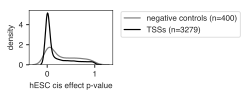

In [20]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(HUES64_cis[HUES64_cis["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(HUES64_cis[HUES64_cis["ctrl_status"] == "control"]))
sns.distplot(HUES64_cis[HUES64_cis["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(HUES64_cis[HUES64_cis["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("hESC cis effect p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("HUES64_cis_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

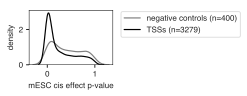

In [21]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(mESC_cis[mESC_cis["ctrl_status"] == "control"]["pval"], hist=False, color="gray",
             label="negative controls (n=%s)" % len(mESC_cis[mESC_cis["ctrl_status"] == "control"]))
sns.distplot(mESC_cis[mESC_cis["ctrl_status"] != "control"]["pval"], hist=False, color="black",
             label="TSSs (n=%s)" % len(mESC_cis[mESC_cis["ctrl_status"] != "control"]))

plt.ylabel("density")
plt.xlabel("mESC cis effect p-value")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("mESC_cis_cis_ctrl_pval_dist.pdf", dpi="figure", bbox_inches="tight")

In [22]:
HUES64_cis["abs_logFC"] = np.abs(HUES64_cis["logFC"])
mESC_cis["abs_logFC"] = np.abs(mESC_cis["logFC"])

In [23]:
order = ["control", "TSS"]
pal = {"control": "gray", "TSS": "black"}

4.48494920721e-58


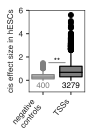

In [24]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=HUES64_cis, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("cis effect size in hESCs")

for i, label in enumerate(order):
    n = len(HUES64_cis[HUES64_cis["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.8), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 6))

# calc p-vals b/w dists
dist1 = np.asarray(HUES64_cis[HUES64_cis["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(HUES64_cis[HUES64_cis["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 1.5, 0, 1.3, pval, fontsize)
fig.savefig("HUES64_cis_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

1.12473451278e-51


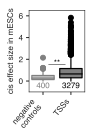

In [25]:
fig = plt.figure(figsize=(1, 1.5))
ax = sns.boxplot(data=mESC_cis, x="ctrl_status", y="abs_logFC", flierprops = dict(marker='o', markersize=5), 
                 order=order, palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["negative\ncontrols", "TSSs"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("cis effect size in mESCs")

for i, label in enumerate(order):
    n = len(mESC_cis[mESC_cis["ctrl_status"] == label])
    color = pal[label]
    ax.annotate(str(n), xy=(i, -0.8), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-1, 6.5))

# calc p-vals b/w dists
dist1 = np.asarray(mESC_cis[mESC_cis["ctrl_status"] == "control"]["abs_logFC"])
dist2 = np.asarray(mESC_cis[mESC_cis["ctrl_status"] != "control"]["abs_logFC"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 1.5, 0, 1.3, pval, fontsize)
fig.savefig("mESC_cis_ctrl_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 3. classify cis effects

In [26]:
HUES64_cis["cis_status"] = HUES64_cis.apply(cis_status, axis=1)
HUES64_cis["cis_status_detail"] = HUES64_cis.apply(cis_status_detail, axis=1)
HUES64_cis.cis_status_detail.value_counts()

no cis effect                    1900
cis effect\n(higher in human)     906
cis effect\n(higher in mouse)     873
Name: cis_status_detail, dtype: int64

In [27]:
mESC_cis["cis_status"] = mESC_cis.apply(cis_status, axis=1)
mESC_cis["cis_status_detail"] = mESC_cis.apply(cis_status_detail, axis=1)
mESC_cis.cis_status_detail.value_counts()

no cis effect                    2750
cis effect\n(higher in mouse)     548
cis effect\n(higher in human)     381
Name: cis_status_detail, dtype: int64

## 4. merge cis effects w/ native effects data

In [28]:
HUES64_cis["hg19_id"] = HUES64_cis["index"].str.split("__", expand=True)[0]
HUES64_cis["biotype_hg19"] = HUES64_cis["index"].str.split("__", expand=True)[1]
HUES64_cis["mm9_id"] = HUES64_cis["index"].str.split("__", expand=True)[2]
HUES64_cis["biotype_mm9"] = HUES64_cis["index"].str.split("__", expand=True)[3]
HUES64_cis.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status,abs_logFC,cis_status,cis_status_detail,hg19_id,biotype_hg19,mm9_id,biotype_mm9
0,h.2__div_lnc__m.1__div_lnc,0.091105,0.762777,0.830745,1,14,5,4,-0.095107,TSS,0.095107,no cis effect,no cis effect,h.2,div_lnc,m.1,div_lnc
1,h.3__div_lnc__m.2__antisense,12.079789,0.000510,0.001793,1,13,5,4,1.622121,TSS,1.622121,significant cis effect,cis effect\n(higher in mouse),h.3,div_lnc,m.2,antisense
2,h.4__antisense_upep__m.3__protein_coding,2.032246,0.153993,0.237146,1,14,5,4,-0.341496,TSS,0.341496,no cis effect,no cis effect,h.4,antisense_upep,m.3,protein_coding
3,h.5__intergenic__m.4__intergenic_upep,0.329227,0.566114,0.668696,1,14,5,4,0.129111,TSS,0.129111,no cis effect,no cis effect,h.5,intergenic,m.4,intergenic_upep
4,h.6__intergenic__m.4__intergenic_upep,19.723218,0.000009,0.000052,1,14,5,4,-1.031535,TSS,1.031535,significant cis effect,cis effect\n(higher in human),h.6,intergenic,m.4,intergenic_upep


In [29]:
mESC_cis["hg19_id"] = mESC_cis["index"].str.split("__", expand=True)[0]
mESC_cis["biotype_hg19"] = mESC_cis["index"].str.split("__", expand=True)[1]
mESC_cis["mm9_id"] = mESC_cis["index"].str.split("__", expand=True)[2]
mESC_cis["biotype_mm9"] = mESC_cis["index"].str.split("__", expand=True)[3]
mESC_cis.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,ctrl_status,abs_logFC,cis_status,cis_status_detail,hg19_id,biotype_hg19,mm9_id,biotype_mm9
0,h.2__div_lnc__m.1__div_lnc,0.214029,0.643628,0.777127,1,14,5,4,-0.200274,TSS,0.200274,no cis effect,no cis effect,h.2,div_lnc,m.1,div_lnc
1,h.3__div_lnc__m.2__antisense,0.886815,0.346342,0.515658,1,13,5,4,0.725192,TSS,0.725192,no cis effect,no cis effect,h.3,div_lnc,m.2,antisense
2,h.4__antisense_upep__m.3__protein_coding,5.341382,0.020825,0.072360,1,14,5,4,-0.843083,TSS,0.843083,no cis effect,no cis effect,h.4,antisense_upep,m.3,protein_coding
3,h.5__intergenic__m.4__intergenic_upep,0.754080,0.385188,0.557577,1,14,5,4,0.261450,TSS,0.261450,no cis effect,no cis effect,h.5,intergenic,m.4,intergenic_upep
4,h.6__intergenic__m.4__intergenic_upep,4.678432,0.030544,0.094907,1,14,5,4,-0.689592,TSS,0.689592,no cis effect,no cis effect,h.6,intergenic,m.4,intergenic_upep


In [30]:
HUES64_cis_sub = HUES64_cis[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                             "cis_status", "cis_status_detail"]]
HUES64_cis_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_cis_HUES64", "logFC_cis_HUES64", 
                          "abs_logFC_cis_HUES64", "cis_status_HUES64", "cis_status_detail_HUES64"]

In [31]:
mESC_cis_sub = mESC_cis[["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr", "logFC", "abs_logFC",
                         "cis_status", "cis_status_detail"]]
mESC_cis_sub.columns = ["hg19_id", "biotype_hg19", "mm9_id", "biotype_mm9", "fdr_cis_mESC", "logFC_cis_mESC", 
                        "abs_logFC_cis_mESC", "cis_status_mESC", "cis_status_detail_mESC"]

In [32]:
data = results.merge(HUES64_cis_sub, 
                     left_on=["hg19_id", "biotype_hg19", 
                              "mm9_id", "biotype_mm9"], 
                     right_on=["hg19_id", "biotype_hg19", 
                               "mm9_id", "biotype_mm9"]).merge(mESC_cis_sub,
                                                               left_on=["hg19_id", "biotype_hg19", 
                                                                        "mm9_id", "biotype_mm9"], 
                                                               right_on=["hg19_id", "biotype_hg19", 
                                                                         "mm9_id", "biotype_mm9"])
print(len(data))
data.sample(5)

3300


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,fdr_cis_HUES64,logFC_cis_HUES64,abs_logFC_cis_HUES64,cis_status_HUES64,cis_status_detail_HUES64,fdr_cis_mESC,logFC_cis_mESC,abs_logFC_cis_mESC,cis_status_mESC,cis_status_detail_mESC
1860,chr3,169482829,169482830,-,"chr3:169482824..169482835,-",intergenic,ENSG00000270141.2,True,False,chr3,...,0.000003,-1.270471,1.270471,significant cis effect,cis effect\n(higher in human),0.000013,-1.962610,1.962610,significant cis effect,cis effect\n(higher in human)
1416,chr15,74220543,74220544,-,"chr15:74220536..74220564,-",antisense,ENSG00000261801.1,True,False,chr9,...,0.000138,0.851948,0.851948,significant cis effect,cis effect\n(higher in mouse),0.097749,0.801624,0.801624,no cis effect,no cis effect
816,chr10,18948298,18948299,+,"chr10:18948288..18948305,+",div_pc,ENSG00000165997.4,True,True,chr2,...,0.146317,-0.700213,0.700213,no cis effect,no cis effect,0.910181,0.085107,0.085107,no cis effect,no cis effect
2231,chr2,239773074,239773075,+,chr2:239772979-239773251,enhancer,chr2:239772979-239773251__POSITIVE,True,False,chr1,...,0.000326,-1.565243,1.565243,significant cis effect,cis effect\n(higher in human),0.170303,-0.933870,0.933870,no cis effect,no cis effect
2456,chr6,2971870,2971871,+,no cage activity,no cage activity,no cage activity,True,False,chr13,...,0.344056,-0.328763,0.328763,no cis effect,no cis effect,0.854996,0.124969,0.124969,no cis effect,no cis effect


In [33]:
data["cis_status_one"] = data.apply(cis_status_one, axis=1)
data["cis_status_detail_one"] = data.apply(cis_status_detail_one, axis=1)

In [34]:
data.cis_status_one.value_counts()

significant cis effect    1810
no cis effect             1490
Name: cis_status_one, dtype: int64

In [35]:
data.cis_status_detail_one.value_counts()

no cis effect                          1490
cis effect\n(higher in mouse)           911
cis effect\n(higher in human)           898
cis effect\n(direction interaction)       1
Name: cis_status_detail_one, dtype: int64

In [36]:
## remove cis effects w/ direction interactions for now! (there aren't any right now)
data_filt = data[~data["cis_status_detail_one"].str.contains("interaction")]

## 5. plot cis effects on scatter plot

In [37]:
# limit to those that are significant in at least 1 context
data_filt = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) | (data_filt["mESC_padj_mm9"] < 0.01)]
len(data_filt)

1663

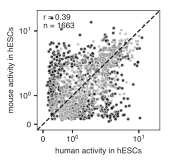

In [38]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

not_sig = data_filt[data_filt["fdr_cis_HUES64"] >= 0.01]
sig = data_filt[data_filt["fdr_cis_HUES64"] < 0.01]

ax.scatter(sig["HUES64_hg19"], sig["HUES64_mm9"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["HUES64_hg19"], not_sig["HUES64_mm9"], s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in hESCs")
plt.ylabel("mouse activity in hESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["HUES64_hg19"])) & 
                   (~pd.isnull(data_filt["HUES64_mm9"]))]
r, p = spearmanr(no_nan["HUES64_hg19"], no_nan["HUES64_mm9"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("cis_HUES64_scatter.pdf", dpi="figure", bbox_inches="tight")

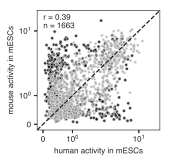

In [39]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

not_sig = data_filt[data_filt["fdr_cis_mESC"] >= 0.01]
sig = data_filt[data_filt["fdr_cis_mESC"] < 0.01]

ax.scatter(sig["mESC_hg19"], sig["mESC_mm9"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["mESC_hg19"], not_sig["mESC_mm9"], s=8, alpha=0.5, 
           color="gray", linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in mESCs")
plt.ylabel("mouse activity in mESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["mESC_hg19"])) & 
                   (~pd.isnull(data_filt["mESC_mm9"]))]
r, p = spearmanr(no_nan["mESC_hg19"], no_nan["mESC_mm9"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("cis_mESC_scatter.pdf", dpi="figure", bbox_inches="tight")

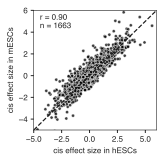

In [40]:
# plot effect size agreement b/w the two cell lines
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(data_filt["logFC_cis_HUES64"], data_filt["logFC_cis_mESC"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")

plt.xlabel("cis effect size in hESCs")
plt.ylabel("cis effect size in mESCs")

ax.plot([-5, 6], [-5, 6], linestyle="dashed", color="k")
ax.set_xlim((-5, 6))
ax.set_ylim((-5, 6))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_cis_HUES64"])) & 
                   (~pd.isnull(data_filt["logFC_cis_mESC"]))]
r, p = spearmanr(no_nan["logFC_cis_HUES64"], no_nan["logFC_cis_mESC"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("cis_effect_bw_cells_scatter.pdf", dpi="figure", bbox_inches="tight")

## 6. plot cis effect sizes across biotypes

In [41]:
# first determine which logFC to use since there are 2 options
data["logFC_cis_max"] = data.apply(cis_logFC_one, axis=1)
data["abs_logFC_cis_max"] = np.abs(data["logFC_cis_max"])

# re-filter
data_filt = data[~data["cis_status_detail_one"].str.contains("interaction")]
data_filt = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) | (data_filt["mESC_padj_mm9"] < 0.01)]
len(data_filt)

1663

In [42]:
clean_order = ["eRNA", "lncRNA", "mRNA"]

0.256582096384
0.0274471299034
0.147732414348


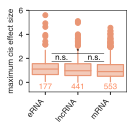

In [43]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_hg19", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "eRNA"]["abs_logFC_cis_max"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "lncRNA"]["abs_logFC_cis_max"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_hg19"] == "mRNA"]["abs_logFC_cis_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

annotate_pval(ax, 0.2, 0.8, 1.75, 0, 1.74, pval12, fontsize)
annotate_pval(ax, 1.2, 1.8, 1.75, 0, 1.74, pval23, fontsize)
annotate_pval(ax, 0.2, 1.8, 2.4, 0, 2.19, pval13, fontsize)

fig.savefig("cis_clean_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [44]:
full_order = ["enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
full_labels = ["eRNA", "lincRNA", "div. lncRNA", "mRNA", "div. mRNA"]

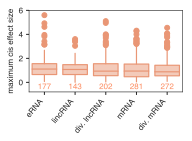

In [45]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_hg19", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[1])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_hg19"] == label])
    color = sns.color_palette("Set2")[1]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6))

fig.savefig("cis_biotype_hg19_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

0.0123983632977
0.000408917767172
0.467471101324


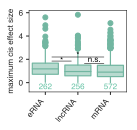

In [46]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="cleaner_biotype_mm9", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=clean_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(clean_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(clean_order):
    n = len(data_filt[data_filt["cleaner_biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6.2))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "eRNA"]["abs_logFC_cis_max"])
dist2 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "lncRNA"]["abs_logFC_cis_max"])
dist3 = np.asarray(data_filt[data_filt["cleaner_biotype_mm9"] == "mRNA"]["abs_logFC_cis_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u13, pval13 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
print(pval13)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

annotate_pval(ax, 0.2, 0.8, 1.85, 0, 1.55, pval12, fontsize)
annotate_pval(ax, 1.2, 1.8, 1.65, 0, 1.64, pval23, fontsize)
annotate_pval(ax, 0.2, 1.8, 2.2, 0, 2., pval13, fontsize)

fig.savefig("cis_clean_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

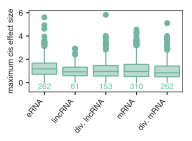

In [47]:
fig = plt.figure(figsize=(2.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_mm9", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_order, color=sns.color_palette("Set2")[0])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(full_order):
    n = len(data_filt[data_filt["biotype_mm9"] == label])
    color = sns.color_palette("Set2")[0]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6.2))

fig.savefig("cis_biotype_mm9_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [48]:
switch_order = ["CAGE turnover", "eRNA", "lncRNA", "mRNA"]

0.963719342746
0.407335329674
0.338902771267


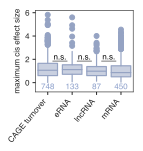

In [49]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch_clean", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(switch_order):
    n = len(data_filt[data_filt["biotype_switch_clean"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6.2))

# calc p-vals b/w dists
dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_cis_max"])
dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_cis_max"])
dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_cis_max"])
dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_cis_max"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]
dist4 = dist4[~np.isnan(dist4)]

u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
print(pval12)

u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval23)

u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
print(pval34)

annotate_pval(ax, 0.2, 0.8, 1.85, 0, 1.84, pval12, fontsize)
annotate_pval(ax, 1.2, 1.8, 1.85, 0, 1.84, pval23, fontsize)
annotate_pval(ax, 2.2, 2.8, 1.85, 0, 1.85, pval34, fontsize)

fig.savefig("cis_clean_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [50]:
full_switch_order = ["CAGE turnover", "enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
full_switch_labels = ["CAGE turnover", "eRNA", "lincRNA", "div. lncRNA", "mRNA", "div. mRNA"]

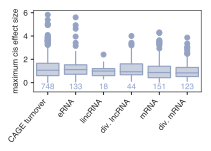

In [51]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.boxplot(data=data_filt, x="biotype_switch", y="abs_logFC_cis_max", 
                 flierprops = dict(marker='o', markersize=5), 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])
mimic_r_boxplot(ax)

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("maximum cis effect size")

for i, label in enumerate(full_switch_order):
    n = len(data_filt[data_filt["biotype_switch"] == label])
    color = sns.color_palette("Set2")[2]
    ax.annotate(str(n), xy=(i, -0.7), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

ax.set_ylim((-0.8, 6.2))

# # calc p-vals b/w dists
# dist1 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "CAGE turnover"]["abs_logFC_native"])
# dist2 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "eRNA"]["abs_logFC_native"])
# dist3 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "lncRNA"]["abs_logFC_native"])
# dist4 = np.asarray(data_filt[data_filt["biotype_switch_clean"] == "mRNA"]["abs_logFC_native"])

# dist1 = dist1[~np.isnan(dist1)]
# dist2 = dist2[~np.isnan(dist2)]
# dist3 = dist3[~np.isnan(dist3)]
# dist4 = dist4[~np.isnan(dist4)]

# u12, pval12 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
# print(pval12)

# u23, pval23 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
# print(pval23)

# u34, pval34 = stats.mannwhitneyu(dist3, dist4, alternative="two-sided", use_continuity=False)
# print(pval34)

# annotate_pval(ax, 0.2, 0.8, 1.75, 0, 1.74, pval12, fontsize)
# annotate_pval(ax, 1.2, 1.8, 1.75, 0, 1.74, pval23, fontsize)
# annotate_pval(ax, 2.2, 2.8, 1.75, 0, 1.75, pval34, fontsize)

fig.savefig("cis_biotype_switch_effectsize_boxplot.pdf", dpi="figure", bbox_inches="tight")

## 7. find % of significant cis effects across biotypes

In [52]:
tots = data_filt.groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_status_one"] != "no cis effect"].groupby("biotype_switch")["hg19_id"].agg("count").reset_index()
full_sig = tots.merge(sig, on="biotype_switch", how="left").fillna(0)
full_sig["percent_sig"] = (full_sig["hg19_id_y"]/full_sig["hg19_id_x"])*100
full_sig.head()

,biotype_switch,hg19_id_x,hg19_id_y,percent_sig
0,CAGE turnover,748,476,63.636364
1,antisense,5,4,80.000000
2,antisense_upep,5,1,20.000000
3,biotype switch,416,246,59.134615
4,div_lnc,44,27,61.363636


In [53]:
# get a hypergeometric p-value for each biotype
res = {}

tot_genes = np.sum(full_sig["hg19_id_x"])
tot_native = np.sum(full_sig["hg19_id_y"])
for biotype in full_switch_order:
    row = full_sig[full_sig["biotype_switch"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
full_sig = full_sig.merge(res, left_on="biotype_switch", right_on="index")
full_sig["padj"] = multicomp.multipletests(full_sig["pval"], method="fdr_bh")[1]
full_sig.head()

,biotype_switch,hg19_id_x,hg19_id_y,percent_sig,index,pval,padj
0,CAGE turnover,748,476,63.636364,CAGE turnover,0.059694,0.179083
1,div_lnc,44,27,61.363636,div_lnc,0.574877,0.976383
2,div_pc,123,70,56.910569,div_pc,0.881955,0.976383
3,enhancer,133,96,72.180451,enhancer,0.004864,0.029185
4,intergenic,18,10,55.555556,intergenic,0.780069,0.976383


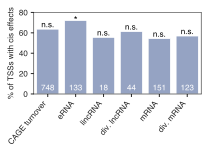

In [54]:
fig = plt.figure(figsize=(3, 1.5))
ax = sns.barplot(data=full_sig, x="biotype_switch", y="percent_sig", 
                 order=full_switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(full_switch_labels, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis effects")

for i, label in enumerate(full_switch_order):
    n = full_sig[full_sig["biotype_switch"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = full_sig[full_sig["biotype_switch"] == label]["percent_sig"].iloc[0]
    fdr = full_sig[full_sig["biotype_switch"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 80))

fig.savefig("perc_sig_cis_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

In [55]:
tots = data_filt.groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
sig = data_filt[data_filt["cis_status_one"] != "no cis effect"].groupby("biotype_switch_clean")["hg19_id"].agg("count").reset_index()
clean_sig = tots.merge(sig, on="biotype_switch_clean", how="left").fillna(0)
clean_sig["percent_sig"] = (clean_sig["hg19_id_y"]/clean_sig["hg19_id_x"])*100
clean_sig.head()

,biotype_switch_clean,hg19_id_x,hg19_id_y,percent_sig
0,CAGE turnover,748,476,63.636364
1,biotype switch,214,129,60.280374
2,eRNA,133,96,72.180451
3,lncRNA,87,53,60.919540
4,mRNA,450,254,56.444444


In [56]:
# get a fisher's exact p-value for each biotype
res = {}

tot_genes = np.sum(clean_sig["hg19_id_x"])
tot_native = np.sum(clean_sig["hg19_id_y"])
for biotype in switch_order:
    row = clean_sig[clean_sig["biotype_switch_clean"] == biotype].iloc[0]
    n_biotype = row.hg19_id_x
    n_native = row.hg19_id_y
    
    pval = stats.hypergeom.sf(n_native-1, tot_genes, n_biotype, tot_native)
    res[biotype] = {"pval": pval}
    
res = pd.DataFrame.from_dict(res, orient="index").reset_index()
clean_sig = clean_sig.merge(res, left_on="biotype_switch_clean", right_on="index")
clean_sig["padj"] = multicomp.multipletests(clean_sig["pval"], method="fdr_bh")[1]
clean_sig.head()

,biotype_switch_clean,hg19_id_x,hg19_id_y,percent_sig,index,pval,padj
0,CAGE turnover,748,476,63.636364,CAGE turnover,0.059694,0.119388
1,eRNA,133,96,72.180451,eRNA,0.004864,0.019457
2,lncRNA,87,53,60.919540,lncRNA,0.593944,0.791925
3,mRNA,450,254,56.444444,mRNA,0.995797,0.995797


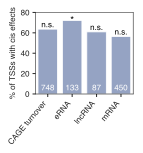

In [57]:
fig = plt.figure(figsize=(1.75, 1.5))
ax = sns.barplot(data=clean_sig, x="biotype_switch_clean", y="percent_sig", 
                 order=switch_order, color=sns.color_palette("Set2")[2])

ax.set_xticklabels(switch_order, rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% of TSSs with cis effects")

for i, label in enumerate(switch_order):
    n = clean_sig[clean_sig["biotype_switch_clean"] == label]["hg19_id_x"].iloc[0]
    ax.annotate(str(n), xy=(i, 2), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color="white", size=fontsize)
    
    p_sig = clean_sig[clean_sig["biotype_switch_clean"] == label]["percent_sig"].iloc[0]
    fdr = clean_sig[clean_sig["biotype_switch_clean"] == label]["padj"].iloc[0]
    if fdr < 0.01:
        txt = "**"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    elif fdr < 0.05:
        txt = "*"
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, -5), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=10)
    else:
        txt = "n.s."
        ax.annotate(txt, xy=(i, p_sig), xycoords="data", xytext=(0, 0.25), textcoords="offset pixels", ha='center', 
                    va='bottom', color="black", size=fontsize)

ax.set_ylim((0, 80))

fig.savefig("perc_sig_cis_clean_biotype_switch.pdf", dpi="figure", bbox_inches="tight")

## 8. look into complete v. partial cis gain/losses

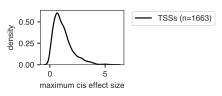

In [58]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(data_filt["abs_logFC_cis_max"], hist=False, color="black",
             label="TSSs (n=%s)" % len(data_filt))

plt.ylabel("density")
plt.xlabel("maximum cis effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
fig.savefig("cis_effectsize_dist.pdf", dpi="figure", bbox_inches="tight")

(-0.2, 25)

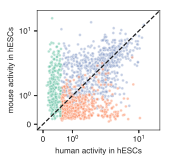

In [59]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig_human_only = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]
sig_mouse_only = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_both = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_neither = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]

ax.scatter(sig_neither["HUES64_hg19"], sig_neither["HUES64_mm9"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_both["HUES64_hg19"], sig_both["HUES64_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[2], linewidths=0.5, edgecolors="white")
ax.scatter(sig_human_only["HUES64_hg19"], sig_human_only["HUES64_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse_only["HUES64_hg19"], sig_mouse_only["HUES64_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in hESCs")
plt.ylabel("mouse activity in hESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

(-0.2, 25)

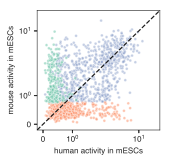

In [60]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig_human_only = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]
sig_mouse_only = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_both = data_filt[(data_filt["HUES64_padj_hg19"] < 0.01) & (data_filt["mESC_padj_mm9"] < 0.01)]
sig_neither = data_filt[(data_filt["HUES64_padj_hg19"] >= 0.01) & (data_filt["mESC_padj_mm9"] >= 0.01)]

ax.scatter(sig_neither["mESC_hg19"], sig_neither["mESC_mm9"], s=10, alpha=0.75, 
           color="gray", linewidths=0.5, edgecolors="white")
ax.scatter(sig_both["mESC_hg19"], sig_both["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[2], linewidths=0.5, edgecolors="white")
ax.scatter(sig_human_only["mESC_hg19"], sig_human_only["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[1], linewidths=0.5, edgecolors="white")
ax.scatter(sig_mouse_only["mESC_hg19"], sig_mouse_only["mESC_mm9"], s=8, alpha=0.5, 
           color=sns.color_palette("Set2")[0], linewidths=0.5, edgecolors="white")

plt.xlabel("human activity in mESCs")
plt.ylabel("mouse activity in mESCs")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.2, 25], [-0.2, 25], linestyle="dashed", color="k")
ax.set_xlim((-0.2, 25))
ax.set_ylim((-0.2, 25))

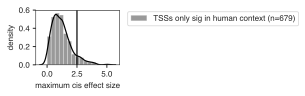

In [61]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(sig_human_only["abs_logFC_cis_max"], hist=True, bins=15, color="black",
             label="TSSs only sig in human context (n=%s)" % len(sig_human_only))

plt.ylabel("density")
plt.xlabel("maximum cis effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
plt.axvline(x=2.5, color="black", zorder=1)

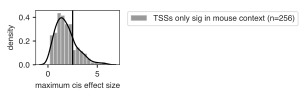

In [62]:
fig = plt.figure(figsize=(1.5, 1))
sns.distplot(sig_mouse_only["abs_logFC_cis_max"], hist=True, bins=15, color="black",
             label="TSSs only sig in mouse context (n=%s)" % len(sig_mouse_only))

plt.ylabel("density")
plt.xlabel("maximum cis effect size")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
plt.axvline(x=2.5, color="black", zorder=1)

In [63]:
###### think about this a little more later, gets confusing because now we have 2 conditions we are checking #####

## 9. compare cis effects to native effects

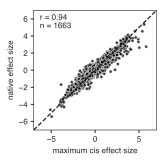

In [64]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(data_filt["logFC_cis_max"], data_filt["logFC_native"], s=10, alpha=0.75, 
           color="black", linewidths=0.5, edgecolors="white")

plt.xlabel("maximum cis effect size")
plt.ylabel("native effect size")

ax.plot([-7, 7], [-7, 7], linestyle="dashed", color="k")
ax.set_xlim((-7, 7))
ax.set_ylim((-7, 7))

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["logFC_cis_max"])) & 
                   (~pd.isnull(data_filt["logFC_native"]))]
r, p = spearmanr(no_nan["logFC_cis_max"], no_nan["logFC_native"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(data_filt)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("cis_v_native_scatter.pdf", dpi="figure", bbox_inches="tight")

In [65]:
data_filt.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'lift_species', 'oligo_type', 'hg19_id', 'mm9_id',
       'cleaner_biotype_hg19', 'cleaner_biotype_mm9', 'biotype_switch',
       'biotype_switch_clean', 'hg19_element', 'mm9_element', 'HUES64_hg19',
       'mESC_hg19', 'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
  

In [66]:
no_native_sub = data_filt[data_filt["native_status"] == "no native effect"]
native_sub = data_filt[data_filt["native_status"] != "no native effect"]

In [67]:
order = ["no cis effect", "significant cis effect"]
pal = {"no cis effect": "gray", "significant cis effect": "black"}

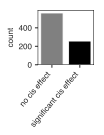

In [68]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=no_native_sub, x="cis_status_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_countplot.no_native.pdf", dpi="figure", bbox_inches="tight")

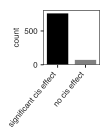

In [69]:
fig, ax = plt.subplots(figsize=(1, 1), nrows=1, ncols=1)

sns.countplot(data=native_sub, x="cis_status_one", ax=ax, order=order[::-1], palette=pal)
ax.set_xticklabels(order[::-1], va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_countplot.native.pdf", dpi="figure", bbox_inches="tight")

In [70]:
len(native_sub)

845

In [71]:
len(native_sub[native_sub["cis_status_one"] == "significant cis effect"])

766

In [72]:
len(native_sub[native_sub["cis_status_one"] == "significant cis effect"])/len(native_sub)

0.906508875739645

In [73]:
native_human_sub = data_filt[data_filt["native_status_detail"].str.contains("human")]
native_mouse_sub = data_filt[data_filt["native_status_detail"].str.contains("mouse")]

In [74]:
order = ["cis effect\n(higher in human)", "cis effect\n(higher in mouse)",
         "no cis effect"]
pal = {"no cis effect": "gray", 
       "cis effect\n(higher in human)": sns.color_palette("Set2")[1],
       "cis effect\n(higher in mouse)": sns.color_palette("Set2")[0]}

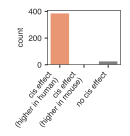

In [75]:
fig, ax = plt.subplots(figsize=(1.3, 1), nrows=1, ncols=1)

sns.countplot(data=native_human_sub, x="cis_status_detail_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_countplot_detail.native_human.pdf", dpi="figure", bbox_inches="tight")

In [76]:
order = ["cis effect\n(higher in mouse)", "cis effect\n(higher in human)",
         "no cis effect"]

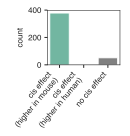

In [77]:
fig, ax = plt.subplots(figsize=(1.3, 1), nrows=1, ncols=1)

sns.countplot(data=native_mouse_sub, x="cis_status_detail_one", ax=ax, order=order, palette=pal)
ax.set_xticklabels(order, va="top", ha="right", rotation=50)
ax.set_xlabel("")
fig.savefig("cis_countplot_detail.native_mouse.pdf", dpi="figure", bbox_inches="tight")

## 10. examine how cis effects correlate with sequence alignment

In [78]:
data_filt = data_filt.merge(align, on=["hg19_id", "mm9_id"])
data_filt.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,logFC_cis_mESC,abs_logFC_cis_mESC,cis_status_mESC,cis_status_detail_mESC,cis_status_one,cis_status_detail_one,logFC_cis_max,abs_logFC_cis_max,seq_alignment_score,seq_alignment_string
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,-0.200274,0.200274,no cis effect,no cis effect,no cis effect,no cis effect,-0.200274,0.200274,255.0,-CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCG...
1,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,0.261450,0.261450,no cis effect,no cis effect,no cis effect,no cis effect,0.261450,0.261450,148.3,----------------------------------------------...
2,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,-0.689592,0.689592,no cis effect,no cis effect,significant cis effect,cis effect\n(higher in human),-1.031535,1.031535,200.7,--CA---TA------------CAC--A------------CACGCA-...
3,chr1,71547031,71547032,+,"chr1:71547013..71547057,+",div_lnc,ENSG00000229956.5,True,True,chr3,...,0.018089,0.018089,no cis effect,no cis effect,no cis effect,no cis effect,-0.166486,0.166486,165.8,TAAACTC-A-CAGGCGCCATA----AGGACAA-CCCAGG--CAGGA...
4,chr1,101491462,101491463,+,"chr1:101491406..101491471,+",div_upep,ENSG00000233184.2,True,True,chr3,...,-0.302568,0.302568,no cis effect,no cis effect,no cis effect,no cis effect,-0.608437,0.608437,157.2,C-G-CCGGCCTC--ACC-TACGGTGCCGCA------A-A-ATGCT-...


In [79]:
data_filt.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'lift_species', 'oligo_type', 'hg19_id', 'mm9_id',
       'cleaner_biotype_hg19', 'cleaner_biotype_mm9', 'biotype_switch',
       'biotype_switch_clean', 'hg19_element', 'mm9_element', 'HUES64_hg19',
       'mESC_hg19', 'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
  

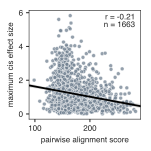

In [80]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="seq_alignment_score", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# # highlight the complete
# sub = data_filt[data_filt["native_status_complete"].str.contains("complete")]
# ax.scatter(sub["seq_alignment_score"], sub["abs_logFC_cis_max"], color="black", s=15, alpha=1, linewidth=0.5,
#            edgecolor="white")

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["seq_alignment_score"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["seq_alignment_score"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("pairwise alignment score")
plt.ylabel("maximum cis effect size")
fig.savefig("cis_effect_v_alignment.pdf", dpi="figure", bbox_inches="tight")

In [81]:
p

3.1568646967149095e-18

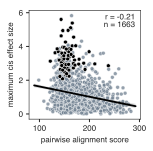

In [82]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=data_filt, x="seq_alignment_score", y="abs_logFC_cis_max", color="slategray", fit_reg=True,
                 scatter_kws={"s": 15, "alpha": 0.75, "linewidth": 0.5, "edgecolor": "white"}, 
                 line_kws={"color": "black"})

# highlight the complete
sub = data_filt[data_filt["native_status_complete"].str.contains("complete")]
ax.scatter(sub["seq_alignment_score"], sub["abs_logFC_cis_max"], color="black", s=15, alpha=1, linewidth=0.5,
           edgecolor="white")

# annotate corr
no_nan = data_filt[(~pd.isnull(data_filt["seq_alignment_score"])) & 
                   (~pd.isnull(data_filt["abs_logFC_cis_max"]))]
r, p = spearmanr(no_nan["seq_alignment_score"], no_nan["abs_logFC_cis_max"])
ax.text(0.95, 0.97, "r = {:.2f}".format(r), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.95, 0.90, "n = %s" % (len(no_nan)), ha="right", va="top", fontsize=fontsize,
        transform=ax.transAxes)
        
plt.xlabel("pairwise alignment score")
plt.ylabel("maximum cis effect size")
fig.savefig("cis_effect_v_alignment.completes_highlighted.pdf", dpi="figure", bbox_inches="tight")

## 11. write results file

In [83]:
data.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'lift_species', 'oligo_type', 'hg19_id', 'mm9_id',
       'cleaner_biotype_hg19', 'cleaner_biotype_mm9', 'biotype_switch',
       'biotype_switch_clean', 'hg19_element', 'mm9_element', 'HUES64_hg19',
       'mESC_hg19', 'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
  

In [84]:
data.to_csv("%s/native_and_cis_effects_data.txt" % results_dir, sep="\t", index=False)